In [1]:
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

/Users/yao/Downloads/School/Work/Portfolio_projects/Time-series-forecast/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Prophet expects DataFrame to have 2 columns (ds: datetime object and y: the target metrics)

In [13]:
df = pd.read_csv("../data/PJME_hourly.csv", parse_dates=["Datetime"]).rename(
    columns={'Datetime': 'ds', 'PJME_MW': 'y'}
)

Split data into train and test sets

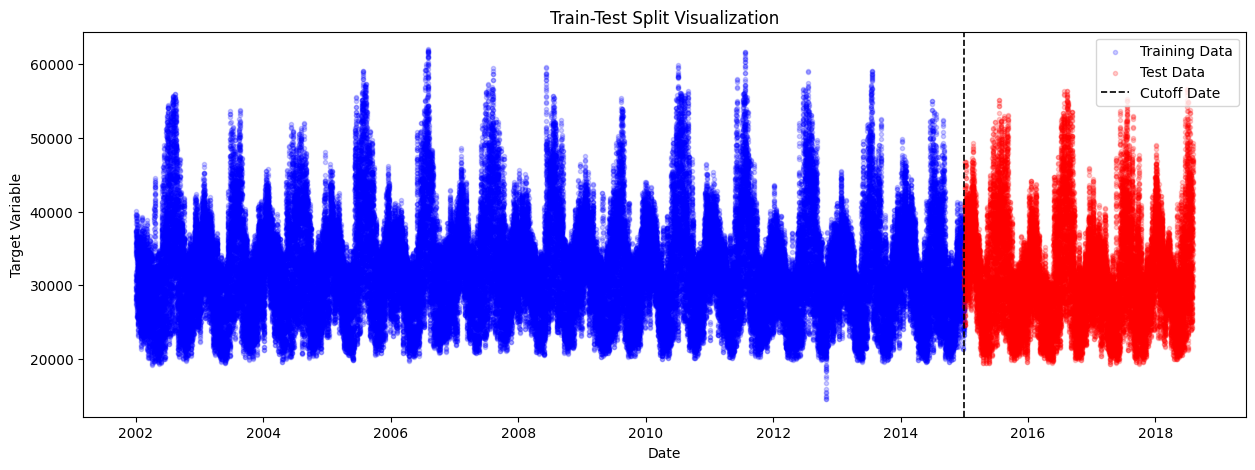

In [4]:
#set cutoff date
cutoff_date = '2015-01-01'
train_set = df[df['ds'] < cutoff_date]
test_set = df[df['ds'] >= cutoff_date]

plt.figure(figsize=(15, 5))

plt.scatter(train_set['ds'], train_set['y'], 
         color='blue', marker='.' , alpha=0.2, label='Training Data')

plt.scatter(test_set['ds'], test_set['y'], 
         color='red', marker='.', alpha=0.2, label='Test Data')

plt.axvline(pd.to_datetime(cutoff_date), 
            color='black', 
            linestyle='--', 
            linewidth= 1.2,
            label='Cutoff Date')

# Formatting
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()




Model

In [5]:
%%time
model = Prophet()
model.fit(train_set)

21:58:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 13.9 s, sys: 1.28 s, total: 15.2 s
Wall time: 2min 19s


In [6]:
forecast = model.predict(test_set)

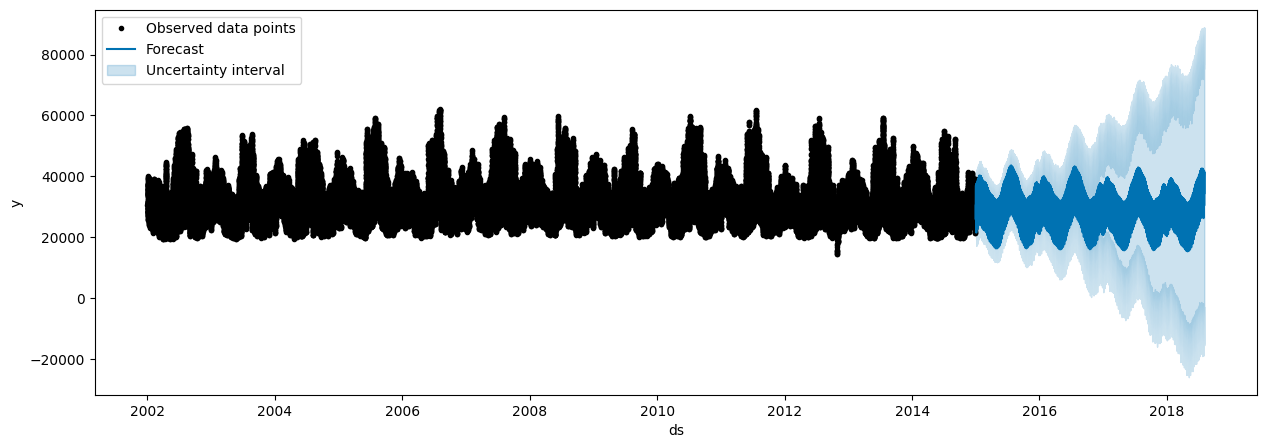

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
fig = model.plot(forecast, ax=ax)
plt.legend()
plt.grid(False)

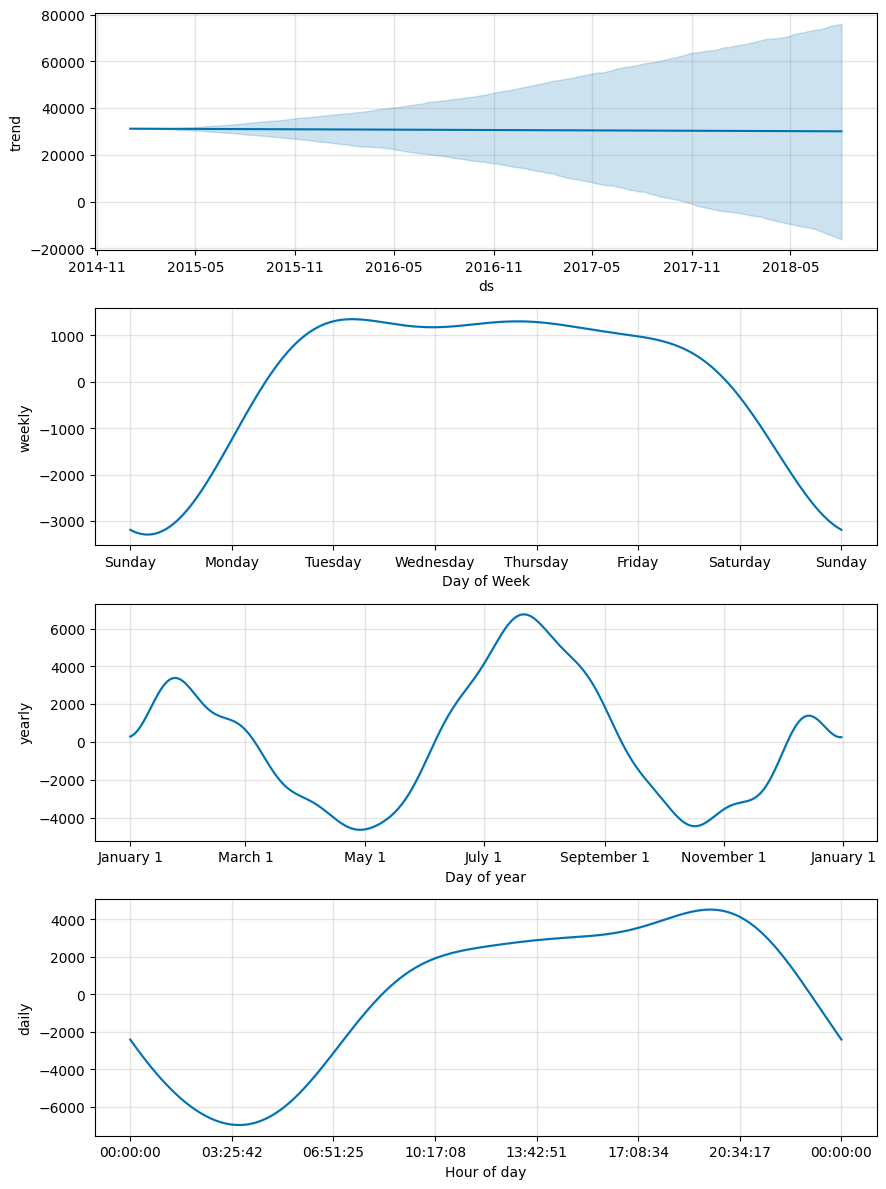

In [8]:
fig = model.plot_components(forecast)

Comparing forecast to actual

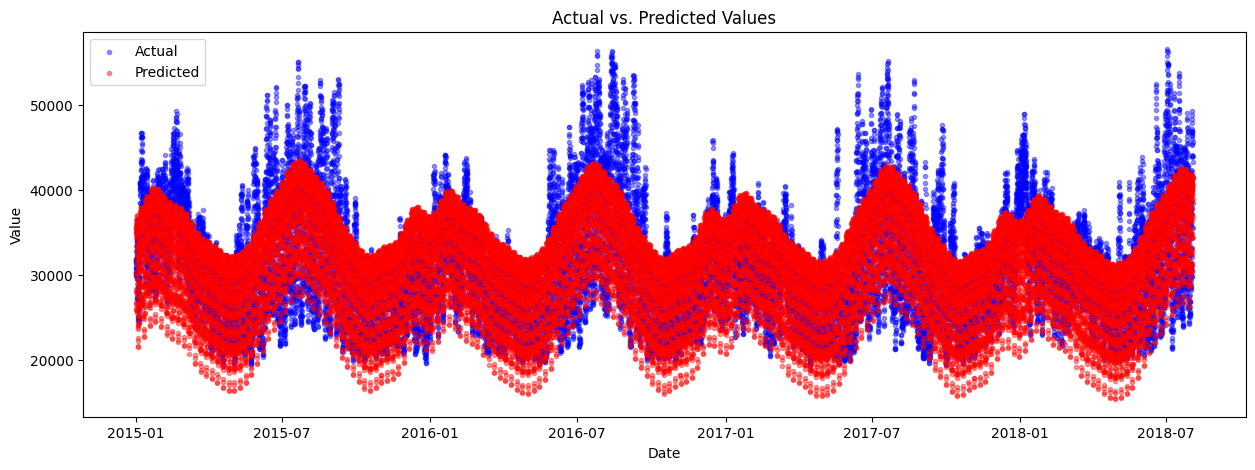

In [9]:
# Plot actual values

fig = plt.subplots(figsize=(15,5))

plt.scatter(test_set['ds'], test_set['y'], label='Actual', color='blue', alpha=0.4, marker='.')
plt.scatter(forecast['ds'], forecast['yhat'], label='Predicted', color='red', alpha=0.4, marker='.')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [11]:
# Compute error metrics
mae = mean_absolute_error(test_set['y'], forecast['yhat'])
mape = mean_absolute_percentage_error(test_set['y'], forecast['yhat']) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 5180.61
MAPE: 16.51%


In [12]:
combined = forecast[['ds','yhat']].merge(test_set[['ds','y']], on='ds')

#calc abs error
combined['abs error'] = abs(combined['yhat'] - combined['y'])

# combined[['ds','abs error']].sort_values(by='abs error').tail(50)

worst = combined.sort_values(by='abs error').tail(100)



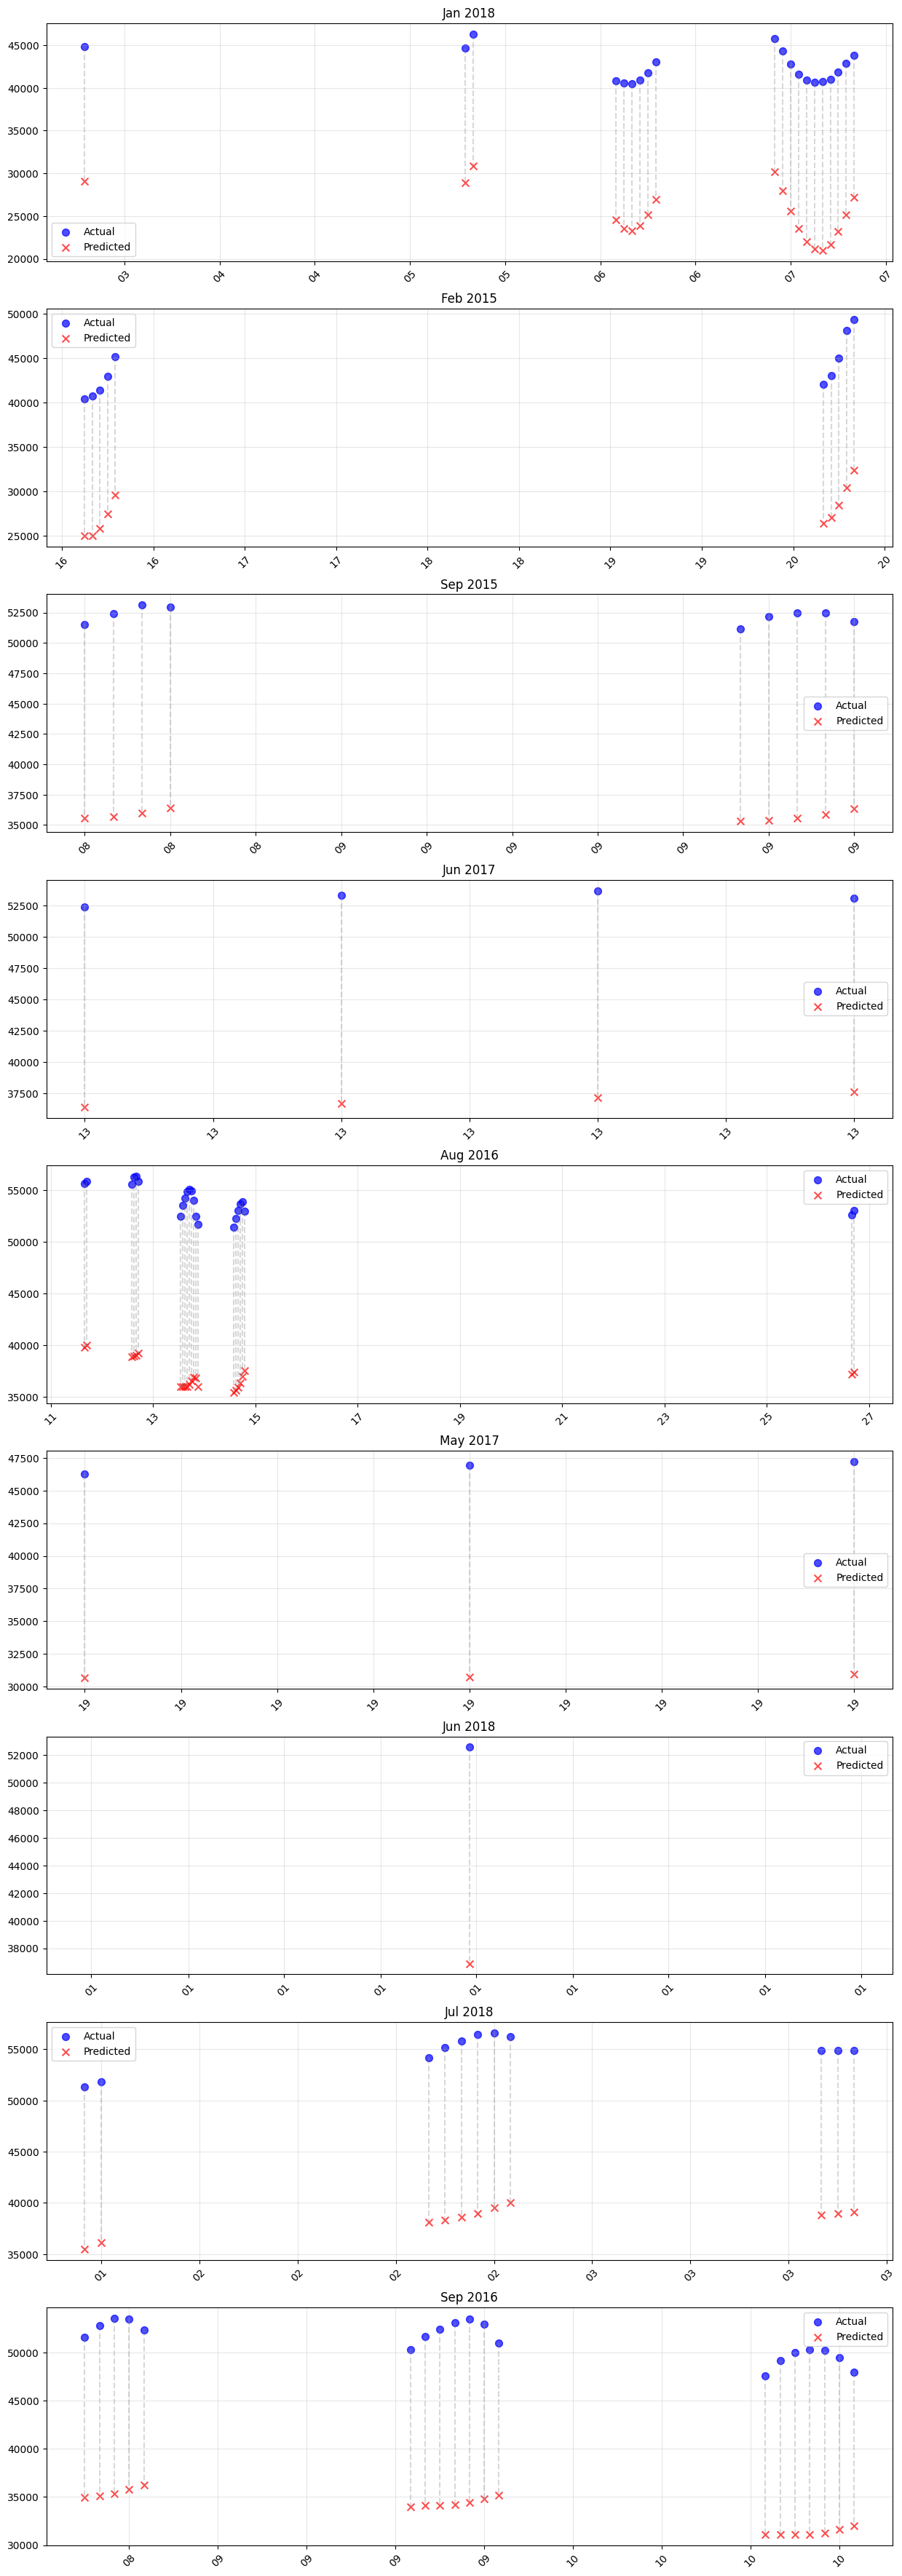

In [13]:
import matplotlib.dates as mdates
from calendar import month_abbr 

worst['month_year'] = worst['ds'].dt.to_period('M')

unique_months = worst['month_year'].unique()

n_rows = len(unique_months) 
fig, axes = plt.subplots(n_rows, 1, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

# Plot each month in a subplot
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = worst[worst['month_year'] == month]
    
    # Sort by date within the month
    month_data = month_data.sort_values('ds')
    
    # Plot actual vs. predicted
    ax.scatter(month_data['ds'], month_data['y'], color='blue', label='Actual', alpha=0.7, s=50)
    ax.scatter(month_data['ds'], month_data['yhat'], color='red', label='Predicted', alpha=0.7, s=50, marker='x')
    ax.vlines(month_data['ds'], month_data['y'], month_data['yhat'], color='gray', alpha=0.3, linestyle='--')
    
    # Formatting
    ax.set_title(f"{month.strftime('%b %Y')}")  # e.g., "Jan 2023"
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Show day of month
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.legend()


In [26]:
def plot_time_window(start_date, end_date, ax=None):
    """
    Plot a time window between `start_date` and `end_date`, highlighting the worst prediction in the window.
    """
    if ax is None:
        ax = plt.gca()
    
    # Filter data within the window
    window_data = combined[
        (combined['ds'] >= start_date) & 
        (combined['ds'] <= end_date)
    ]
    
    # Plot actual and predicted values
    ax.plot(window_data['ds'], window_data['y'], label='Actual', color='blue', marker='o', markersize=4, alpha=0.7)
    ax.plot(window_data['ds'], window_data['yhat'], label='Predicted', color='red', marker='o', markersize=4, alpha=0.7)
    
    # Highlight the worst prediction date IN THE WINDOW
    if not window_data.empty:
        worst_point = window_data.sort_values(by='abs error').tail(1)
        ax.scatter(
            worst_point['ds'], 
            worst_point['y'], 
            edgecolor='black',  # Border color
            facecolor='none',   # Empty fill
            s=100,              # Marker size
            zorder=5, 
            linewidth=1.5,      # Border thickness
            marker='o',         # Circle marker
            label='Worst Error (Actual)'
        )

        ax.scatter(
            worst_point['ds'], 
            worst_point['yhat'], 
            edgecolor='black', 
            facecolor='none', 
            s=100, 
            zorder=5, 
            linewidth=1.5, 
            marker='o', 
            label='Worst Error (Predicted)'
        )
    else:
        print(f"No data in window {start_date} to {end_date}.")
    
    # Formatting (updated title)
    ax.set_title(f"Window: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.legend()

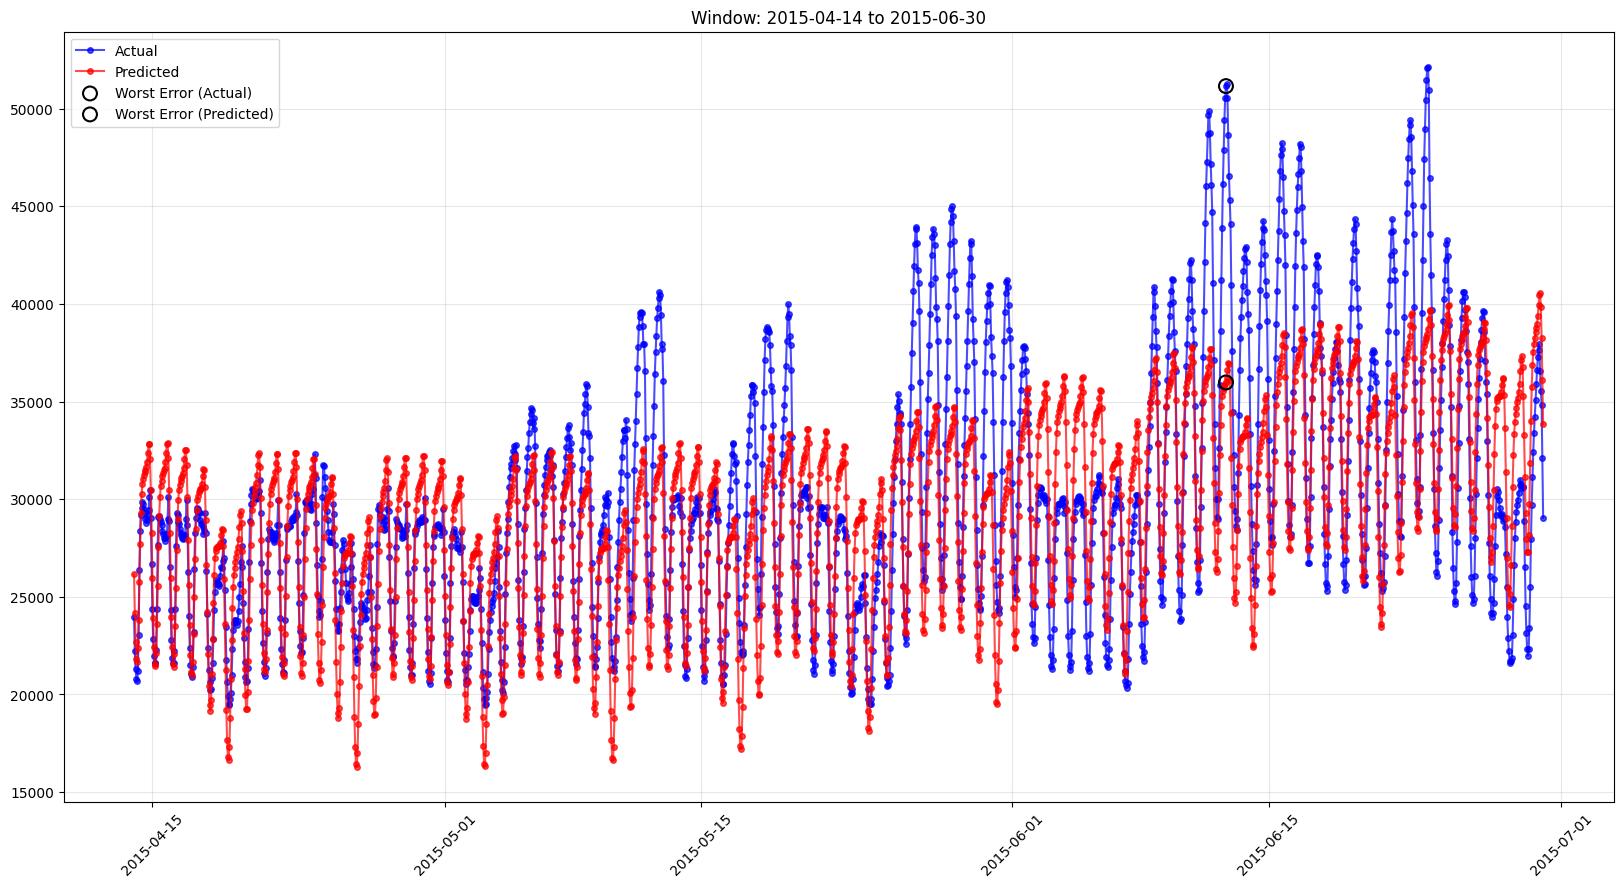

In [20]:
# Define a window (e.g., January 2023)
start = pd.to_datetime('2015-04-14')
end = pd.to_datetime('2015-06-30')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_time_window(start, end, ax=ax)
plt.show()

# Including Holidays and other features


In [15]:
def create_features(df):
    # Temporal features
    df['hour'] = df['ds'].dt.hour
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Summer season regressor (June-August)
    df['is_summer'] = df['ds'].dt.month.between(6, 8).astype(int)
    
    # Special summer weekend feature
    df['summer_weekend'] = df['is_summer'] * df['is_weekend']

    # Condition for summer season
    df['summer_season'] = df['is_summer']
    
    # Cyclical hour encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    return df

# Apply to your dataframe
df = create_features(df.dropna())



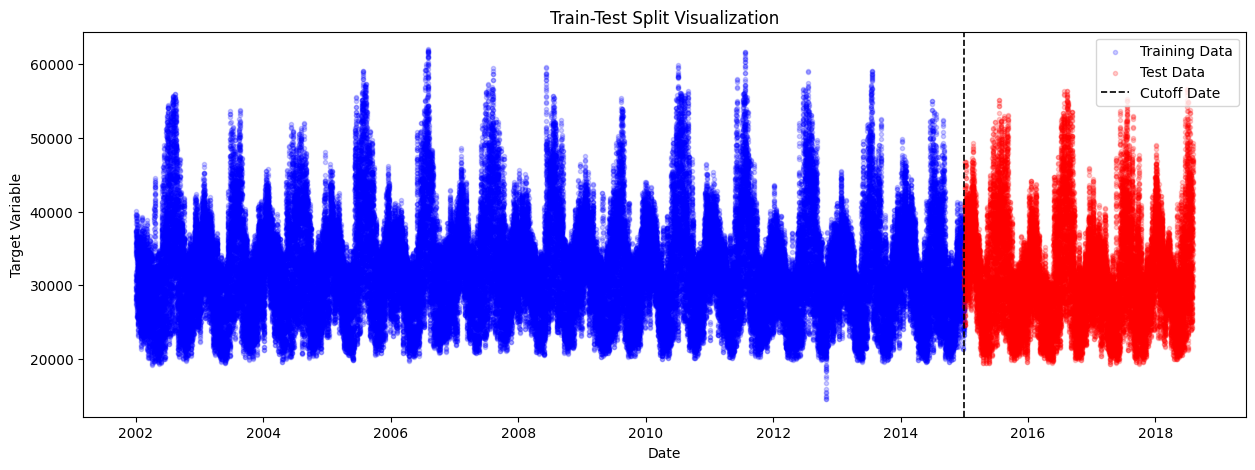

In [16]:
#set cutoff date
cutoff_date = '2015-01-01'
train_set = df[df['ds'] < cutoff_date]
test_set = df[df['ds'] >= cutoff_date]

plt.figure(figsize=(15, 5))

plt.scatter(train_set['ds'], train_set['y'], 
         color='blue', marker='.' , alpha=0.2, label='Training Data')

plt.scatter(test_set['ds'], test_set['y'], 
         color='red', marker='.', alpha=0.2, label='Test Data')

plt.axvline(pd.to_datetime(cutoff_date), 
            color='black', 
            linestyle='--', 
            linewidth= 1.2,
            label='Cutoff Date')

# Formatting
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()

In [37]:
# %%time

# model = Prophet()
# model.add_country_holidays(country_name='US')
# model.fit(train_set)


22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 18.2 s, sys: 2.11 s, total: 20.3 s
Wall time: 4min 13s


In [17]:
df.head()

,ds,y,hour,day_of_week,is_weekend,is_summer,summer_weekend,summer_season,hour_sin,hour_cos
0,2002-12-31 01:00:00,26498.0,1,1,0,0,0,0,0.258819,0.965926
1,2002-12-31 02:00:00,25147.0,2,1,0,0,0,0,0.500000,0.866025
2,2002-12-31 03:00:00,24574.0,3,1,0,0,0,0,0.707107,0.707107
3,2002-12-31 04:00:00,24393.0,4,1,0,0,0,0,0.866025,0.500000
4,2002-12-31 05:00:00,24860.0,5,1,0,0,0,0,0.965926,0.258819


In [18]:
train_set.head()

,ds,y,hour,day_of_week,is_weekend,is_summer,summer_weekend,summer_season,hour_sin,hour_cos
0,2002-12-31 01:00:00,26498.0,1,1,0,0,0,0,0.258819,0.965926
1,2002-12-31 02:00:00,25147.0,2,1,0,0,0,0,0.500000,0.866025
2,2002-12-31 03:00:00,24574.0,3,1,0,0,0,0,0.707107,0.707107
3,2002-12-31 04:00:00,24393.0,4,1,0,0,0,0,0.866025,0.500000
4,2002-12-31 05:00:00,24860.0,5,1,0,0,0,0,0.965926,0.258819


In [19]:
%%time
# Initialize model with core parameters
model = Prophet(
    daily_seasonality=False, 
    weekly_seasonality=False,
    yearly_seasonality=8,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.15,
    n_changepoints=50
)

# Add holidays
model.add_country_holidays(country_name='US')

# Add custom regressors
for feature in ['hour_sin', 'hour_cos', 'is_weekend', 'is_summer', 'summer_weekend', 
                ]:
    if feature in df.columns:
        model.add_regressor(feature)

# Add enhanced seasonalities 
model.add_seasonality(
    name='daily',
    period=1,
    fourier_order=8,
    prior_scale=0.15
)

model.add_seasonality(
    name='summer_daily',
    period=1,
    fourier_order=6,
    prior_scale=0.2,
    condition_name='summer_season'  
)

model.fit(train_set)

19:38:02 - cmdstanpy - INFO - Chain [1] start processing
19:52:11 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 22.2 s, sys: 2.17 s, total: 24.4 s
Wall time: 14min 40s


In [21]:
# model.train_holiday_names

In [20]:
forecast = model.predict(test_set)

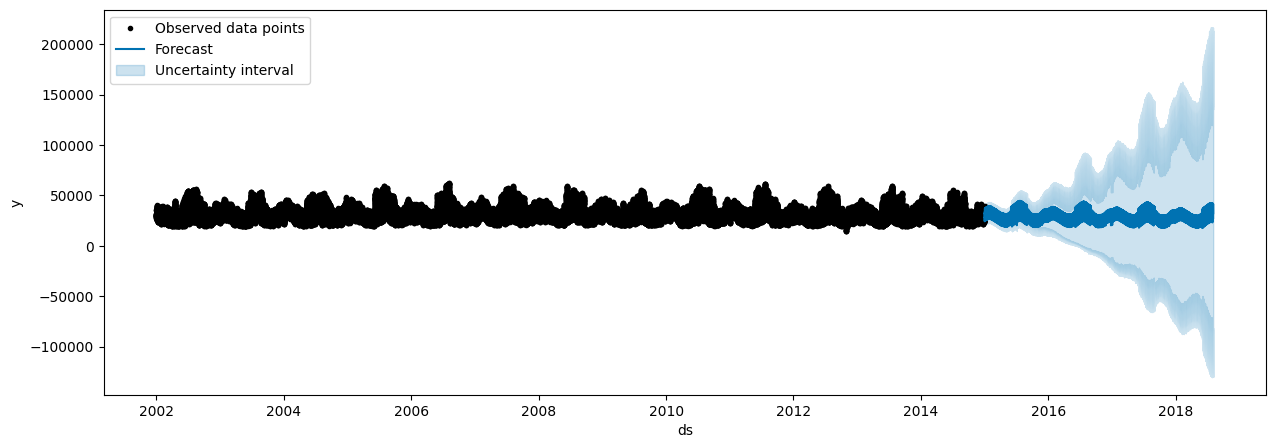

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
fig = model.plot(forecast, ax=ax)
plt.legend()

plt.grid(False)

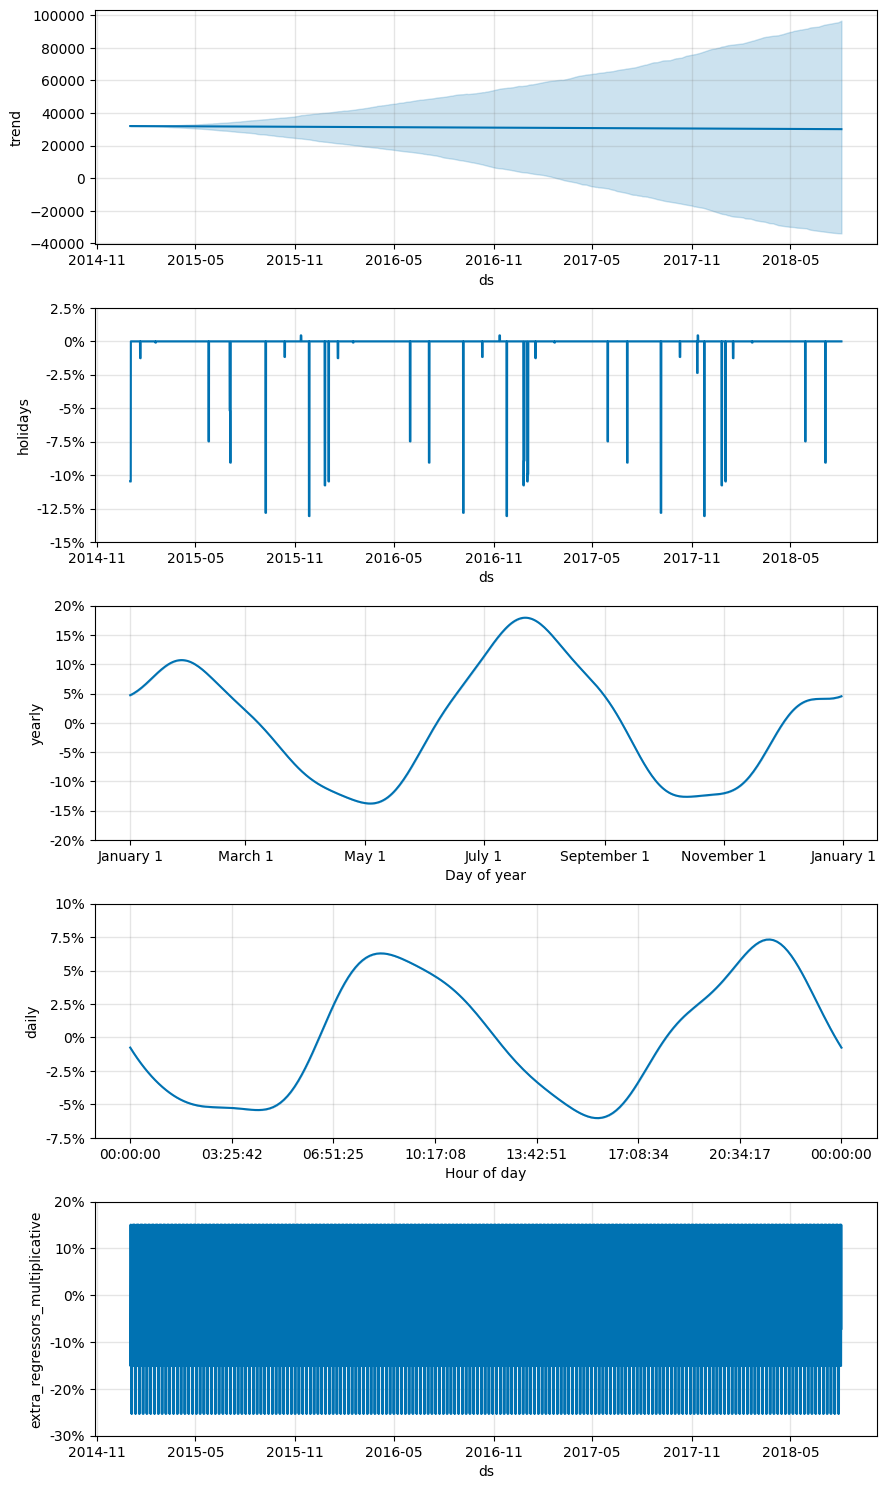

In [71]:
fig = model.plot_components(forecast)

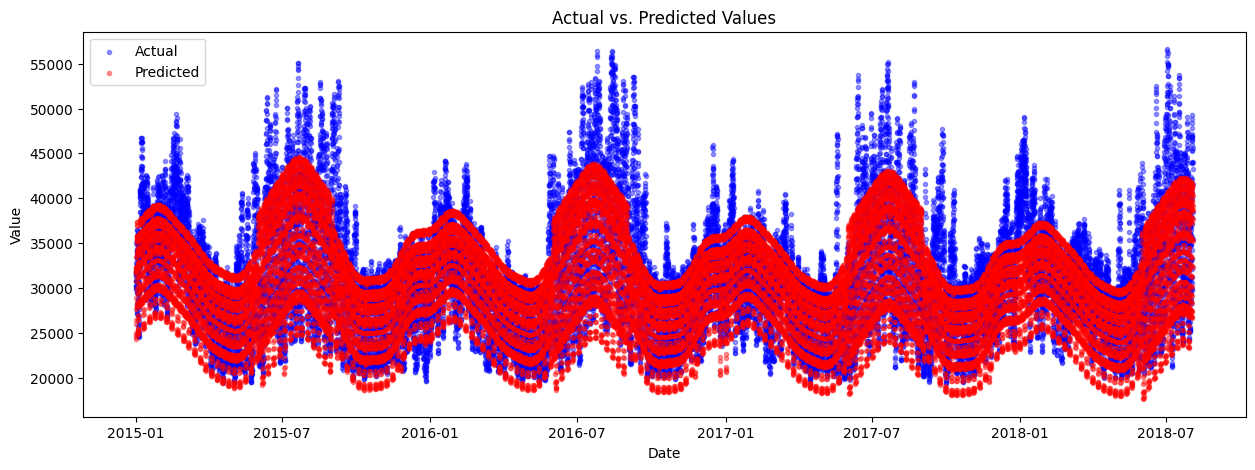

In [22]:
# Plot actual values

fig = plt.subplots(figsize=(15,5))


plt.scatter(test_set['ds'], test_set['y'], label='Actual', color='blue', alpha=0.4, marker='.')
plt.scatter(forecast['ds'], forecast['yhat'], label='Predicted', color='red', alpha=0.4, marker='.')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [23]:
# Compute error metrics
mae = mean_absolute_error(test_set['y'], forecast['yhat'])
mape = mean_absolute_percentage_error(test_set['y'], forecast['yhat']) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 5087.19
MAPE: 15.96%


In [24]:
combined = forecast[['ds','yhat']].merge(test_set[['ds','y']], on='ds')

#calc abs error
combined['abs error'] = abs(combined['yhat'] - combined['y'])

# combined[['ds','abs error']].sort_values(by='abs error').tail(50)

worst = combined.sort_values(by='abs error').tail(100)


NameError: name 'mdates' is not defined

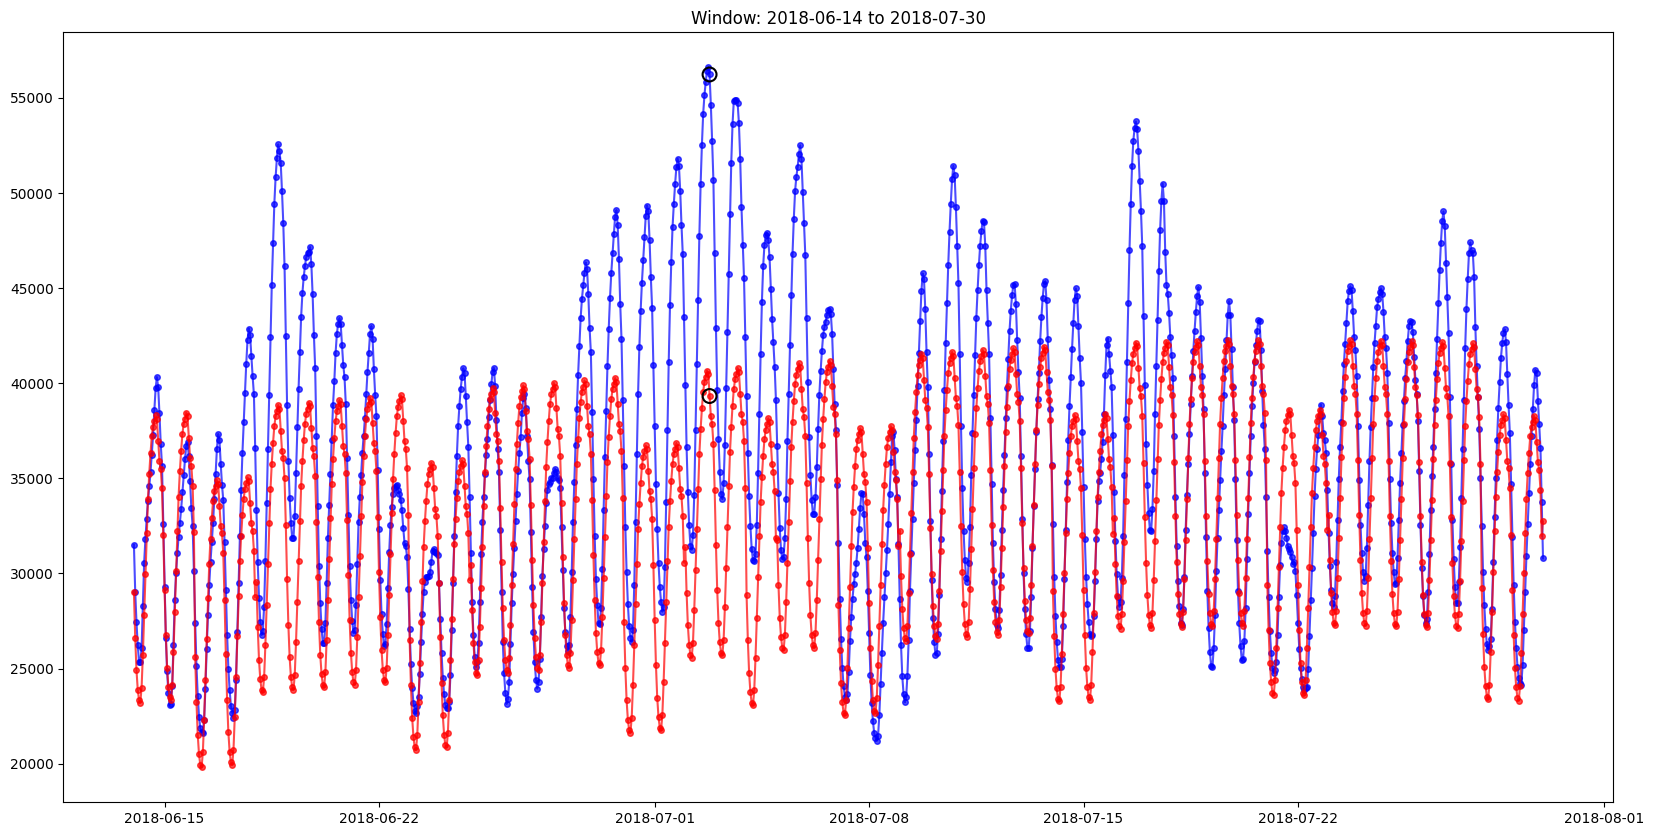

In [27]:
# Define a window (e.g., January 2023)
start = pd.to_datetime('2018-06-14')
end = pd.to_datetime('2018-07-30')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_time_window(start, end, ax=ax)
plt.show()

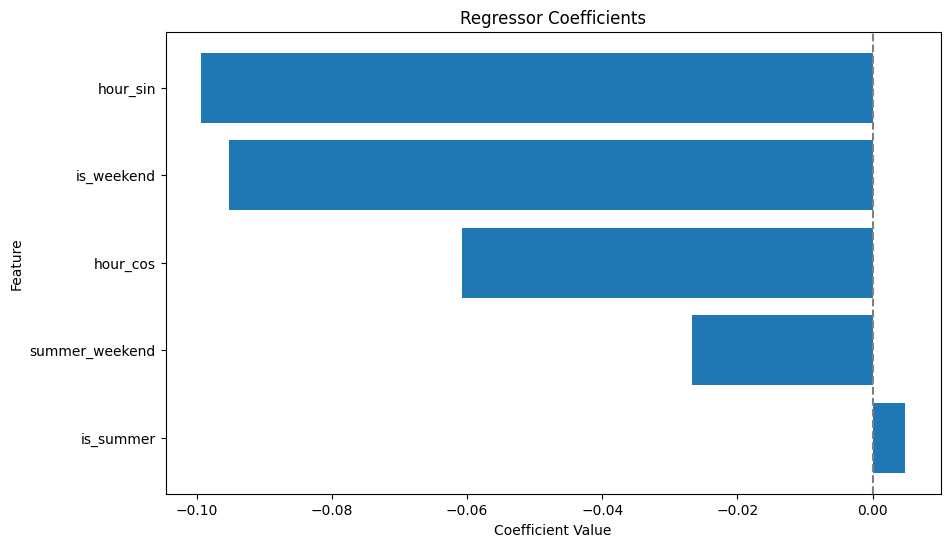

In [28]:
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

# Sort by absolute value of coefficients
sorted_coef = regressor_coef.copy()
sorted_coef['abs_coef'] = sorted_coef['coef'].abs()
sorted_coef = sorted_coef.sort_values('abs_coef', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(sorted_coef['regressor'], sorted_coef['coef'])
plt.title('Regressor Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='grey', linestyle='--')
plt.gca().invert_yaxis()  # Highest at top
plt.show()

In [30]:
pip install python-mango

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.1/746.1 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 3.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.01, 0.075],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.001, 0.05, 0.01, 0.1 ],
    'n_changepoints' : [25, 50, 75, 100],
    'seasonality_mode': ['additive', 'multiplicative']
}

%%time
# Initialize model with core parameters
model = Prophet(
    daily_seasonality=False, 
    weekly_seasonality=False,
    yearly_seasonality=8,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.15,
    n_changepoints=50
)

# Add holidays
model.add_country_holidays(country_name='US')

# Add custom regressors
for feature in ['hour_sin', 'hour_cos', 'is_weekend', 'is_summer', 'summer_weekend', 
                ]:
    if feature in df.columns:
        model.add_regressor(feature)

# Add enhanced seasonalities 
model.add_seasonality(
    name='daily',
    period=1,
    fourier_order=8,
    prior_scale=0.15
)

model.add_seasonality(
    name='summer_daily',
    period=1,
    fourier_order=6,
    prior_scale=0.2,
    condition_name='summer_season'  
)

model.fit(train_set)